In [2]:

import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import lightgbm as lgb
print(lgb.__version__)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)


lgb_train = lgb.Dataset(X_train, y_train, params={'feature_pre_filter':False})
lgb_test = lgb.Dataset(X_test, y_test, params={'feature_pre_filter':False})




4.5.0


NameError: name 'x' is not defined

In [ ]:
from sklearn.metrics import f1_score

threshold=0.5

# Define the F1 Score metric
def F1_metric(y_pred,dataset):
  y_true=dataset.get_label()
  F1 = f1_score(y_true, y_pred>threshold)
  return "F1",F1,True



def sigmoid(x):
    return 1 / (1 + np.exp(-x))



"\n# Custom evaluation metric\ndef custom_eval_metric2(y_true,y_pred):\n    # Convert predictions to probabilities\n    y_pred = 1 / (1 + np.exp(-y_pred))\n    return 'custom_logloss', log_loss(y_true, y_pred), False\n"

In [ ]:
def black_box_function(num_leaves, learning_rate,num_iterations,lambda_l1,lambda_l2,max_depth,min_data_in_leaf):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """

    n_estimators = int(num_leaves)
    num_iterations=int(num_iterations)
    max_depth=int(max_depth)
    num_leaves=int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)

    lambda_l1=round(float(lambda_l1),2)
    lambda_l2=round(float(lambda_l2),2)
    learning_rate=round(float(learning_rate),2)




    # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

    # Using built-in objective
    lgbm_params = {
        'metric':['cross_entropy'],
        'objective': 'cross_entropy',
        'random_seed': 0,
        'force_col_wise': 'true',
        'is_unbalance':True,
        'data_sample_strategy':'bagging',
        'save_binary':True,
        'early_stopping_rounds' : 13,

        'num_leaves':num_leaves,
        'learning_rate': learning_rate,
        'lambda_l1':lambda_l1,
        'lambda_l2':lambda_l2,
        'max_depth':max_depth,
        'num_iterations':num_iterations,
        'min_data_in_leaf':min_data_in_leaf,

        #'evals_result': evals_result,


        #**best_params
    }


    model = lgb.train(
            params=lgbm_params,
            train_set=lgb_train,
            num_boost_round=100,
            feval = F1_metric,
            valid_sets=[lgb_train,lgb_test],

        )


    #clf._Booster=model
    y_pred=model.predict(X_train)>threshold

    return f1_score(y_train,y_pred)

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {
    'num_leaves': (5, 50),
    'learning_rate': (0.05, 0.2),
    'num_iterations': (10, 100),
    'lambda_l1' :(0.01,0.3),
    'lambda_l2':(0.01,0.3),
    'max_depth':(100,300),
    'min_data_in_leaf':(30,200)
}

optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    random_state=1,
)

optimizer.maximize(

    init_points=1,
    n_iter=10
)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 5185
[LightGBM] [Info] Number of data points in the train set: 3161, number of used features: 33
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=30) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1073741824) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 5197
[LightGBM] [Info] Number of data points in the train set: 3161, number of used features: 33
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=30) without explicitly setting 'num_l

In [ ]:
best_params=optimizer.max['params']

best_params['num_iterations']=int(best_params['num_iterations'])
best_params['num_leaves']=int(best_params['num_leaves'])
best_params['max_depth']=int(best_params['max_depth'])
best_params['min_data_in_leaf']=int(best_params['min_data_in_leaf'])

best_params['lambda_l1']=round(float(best_params['lambda_l1']),2)
best_params['lambda_l2']=round(float(best_params['lambda_l2']),2)
best_params['learning_rate']=round(float(best_params['learning_rate']),2)

print(best_params)




{'learning_rate': 0.1,
 'max_depth': 30,
 'n_estimators': 100,
 'num_leaves': 20,
 'reg_alpha': 0.2,
 'reg_lambda': 0.2}

In [ ]:

os.makedirs('lightgbm', exist_ok=True)  
filew= open("lightgbm/lightgbm_best_params.json","w")
filew.write(str(best_params))
filew.close()

In [ ]:

# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

# Using built-in objective
lgbm_params = {

        'metric':['cross_entropy'],
        'objective': 'cross_entropy',
        'random_seed': 0,
        'force_col_wise': 'true',
        'is_unbalance':True,
        'data_sample_strategy':'bagging',
        'save_binary':True,
        'early_stopping_rounds' : 100,
        **best_params
}


model = lgb.train(
    params=lgbm_params,
    train_set=lgb_train,
    num_boost_round=100,
    feval = F1_metric,
    valid_sets=[lgb_train,lgb_test]
)

dec_threshold=0.5

y_pred=model.predict(X_train)>dec_threshold
y_val=model.predict(X_test)>dec_threshold
y_val_prob=model.predict(X_test)


print(f'\nLightGBM Model training accuracy, {accuracy_score(y_train, y_pred)}, F1 score: {f1_score(y_train, y_pred)}')

print(f'\nLightGBM Model testing accuracy, {accuracy_score(y_test, y_val)}, F1 score: {f1_score(y_test, y_val)}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 5297
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 33
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=30) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1073741824) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function

LightGBM Model training accuracy, 0.916751012145749

LightGBM Model testing accuracy, 0.759882005899705


In [ ]:
model_result = lgb.cv(
    params=lgbm_params,
    train_set=lgb_train,
    num_boost_round=100,
    feval = F1_metric,
)

In [ ]:

filew= open("lightgbm/testmodel_params.json","w")
filew.write(str(model.params))
filew.close()

In [39]:
model.trees_to_dataframe()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S2,0-S1,None,Respiratory_rate_mean,66.369400,20.841531,<=,left,None,0.000000,0.000000,3952
1,0,2,0-S2,0-S20,0-S4,0-S0,Temperature_mean,36.837399,35.984630,<=,left,None,-0.121031,626.250000,2505
2,0,3,0-S20,0-L0,0-L21,0-S2,Temperature_min,8.692320,35.250000,<=,left,None,0.017344,18.250000,73
3,0,4,0-L0,None,None,0-S20,None,NaN,NaN,None,None,None,0.060967,13.250000,53
4,0,4,0-L21,None,None,0-S20,None,NaN,NaN,None,None,None,-0.090385,5.000000,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3045,49,5,49-L6,None,None,49-S6,None,NaN,NaN,None,None,None,0.092907,4.499647,23
3046,49,5,49-L7,None,None,49-S6,None,NaN,NaN,None,None,None,-0.000700,3.662174,24
3047,49,3,49-S4,49-L4,49-L5,49-S3,Glucose_min,2.031740,106.500000,<=,left,None,-0.040717,11.330000,75
3048,49,4,49-L4,None,None,49-S4,None,NaN,NaN,None,None,None,0.015316,3.506751,22


In [ ]:
model.feature_importance()

lgb.plot_importance(model,figsize=(10,10))

In [1]:
#model = lgb.Booster(model_file='lightgbm_model.txt')
model.save_model("lightgbm/lightgbm_model.txt")

NameError: name 'model' is not defined

Confusion matrix

 [[1191   64]
 [ 343   97]]

True Positives(TP) =  1191

True Negatives(TN) =  97

False Positives(FP) =  64

False Negatives(FN) =  343
              precision    recall  f1-score   support

         0.0       0.78      0.95      0.85      1255
         1.0       0.60      0.22      0.32       440

    accuracy                           0.76      1695
   macro avg       0.69      0.58      0.59      1695
weighted avg       0.73      0.76      0.72      1695



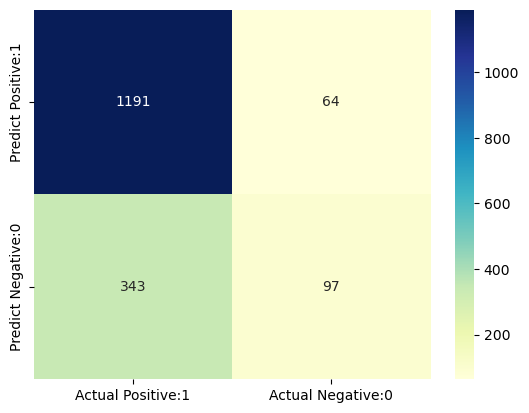

In [ ]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_val)
"""
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
"""

# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                                 index=['Predict Positive:1', 'Predict Negative:0'])

print(classification_report(y_test, y_val))

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')




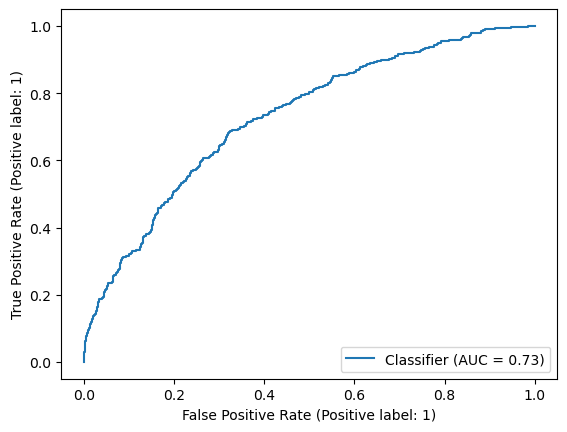

In [ ]:
#https://towardsdatascience.com/understanding-the-roc-curve-in-three-visual-steps-795b1399481c
#https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.RocCurveDisplay.html



import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_auc_score


print("AUC Score: ",roc_auc_score(y_test, y_val_prob))

roc_display = RocCurveDisplay.from_predictions(y_test, y_val_prob)

ax = roc_display.ax_

# Add the diagonal line x=y
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

In [ ]:
# Plot the loss values after optimization
plt.figure(figsize=(10, 6))
plt.plot(model_result['valid cross_entropy-mean'], marker='.', linestyle='-')
plt.title('Loss Value During Optimization')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid()
plt.show()

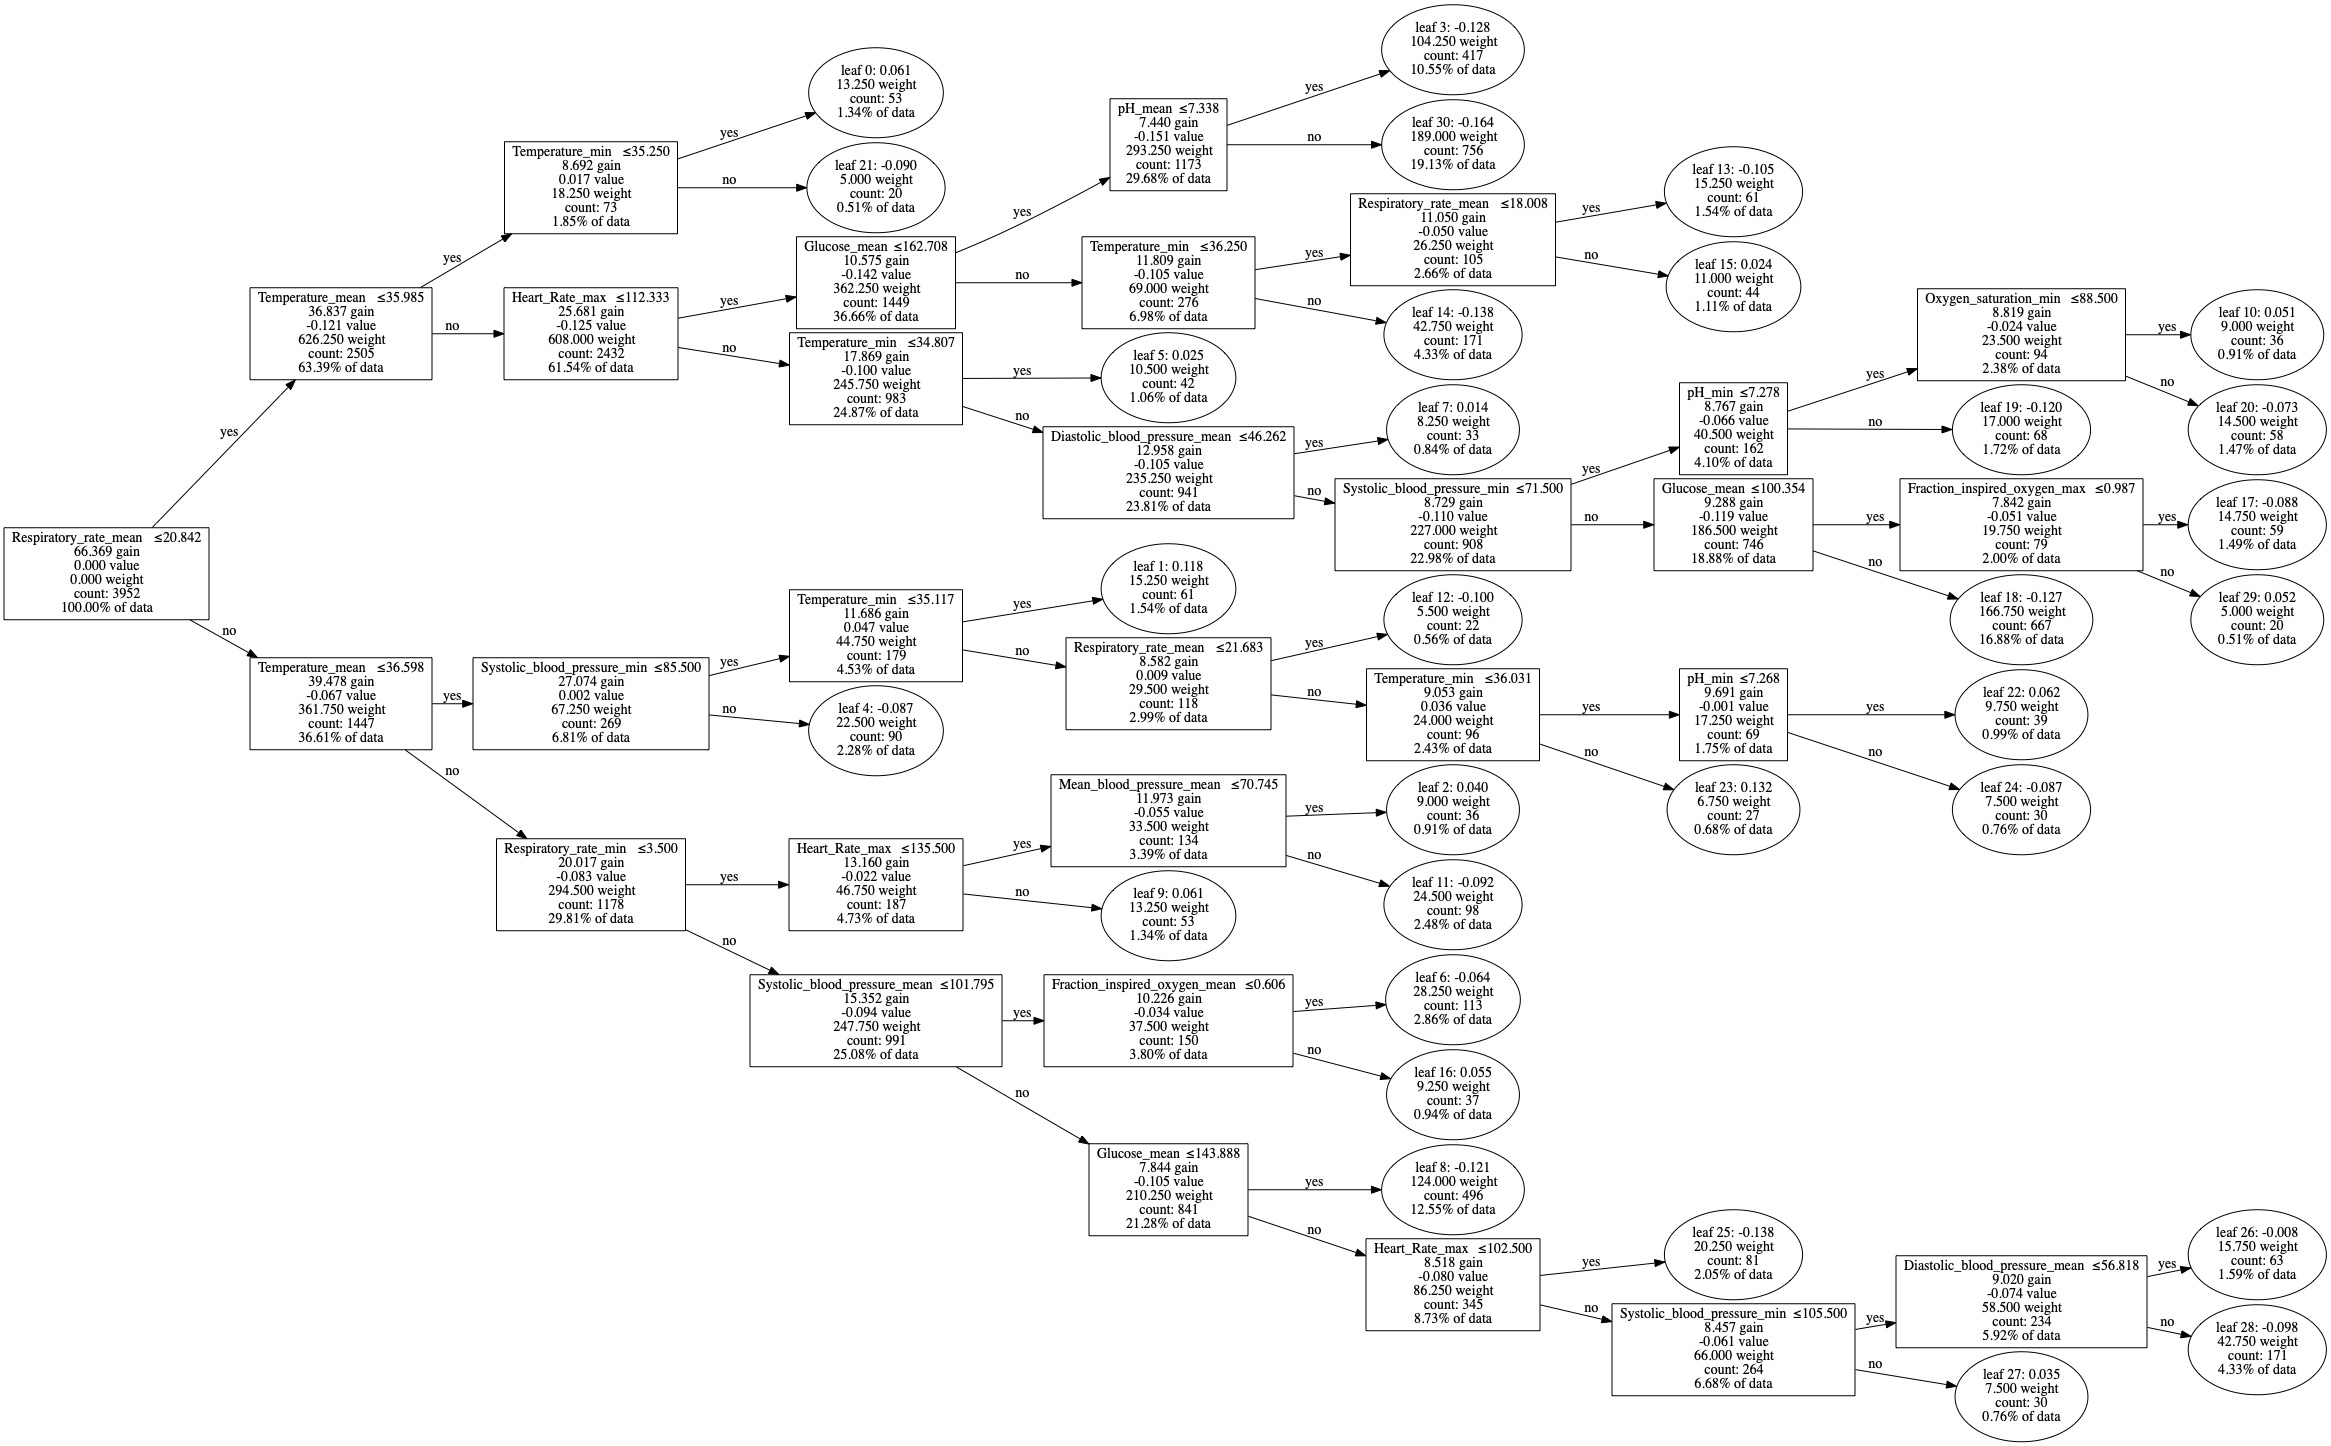

In [ ]:
from PIL import Image

graph = lgb.create_tree_digraph(model, tree_index=0, show_info=['split_gain', 'internal_value', 'internal_count','internal_weight', 'leaf_count', 'leaf_weight', 'data_percentage'])

image=graph.render('lightgbm/lightgbm_plot_tree', format='jpg')

#image = Image.open("example.jpg")
#image.save("lightgbm_plot_tree.jpg")
#https://stackoverflow.com/questions/66475025/how-to-calculate-the-weight-and-value-in-lightgbm

image = Image.open("lightgbm/lightgbm_plot_tree.jpg")
image


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

dec_pred=[i for i in np.arange(0.0,1.01,0.05)]

dec_f1_score=list()
this_precision=list()
this_recall=list()


for best_dec_pred in dec_pred:

      # https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html


      #print(f'\nLightGBM Model training accuracy, {f1_score(y_train, y_pred>best_dec_pred)}')


      y_val_t=y_val_prob>best_dec_pred

      this_f1_score=f1_score(y_test, y_val_t)
      this_precision.append(precision_score(y_test, y_val_t,average='macro',zero_division=0))
      this_recall.append(recall_score(y_test, y_val_t,average='macro',zero_division=0))

      dec_f1_score.append(this_f1_score)

      #print(f'\nLightGBM Model testing accuracy, {this_f1_score}')


(5647, 33)
(5647,)
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 5250
[LightGBM] [Info] Number of data points in the train set: 3556, number of used features: 33
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=50) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1125899906842624) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Using self-defined objective function
[LightGBM] [Info] Total Bins 5241
[LightGBM] [Info] Number of data points in the train set: 3556, number of used features: 33
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=50) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=1125899906842624) in params. Alternatively, pass (

In [ ]:
max_precision=max(this_precision)
max_precision_indx=round(dec_pred[this_precision.index(max_precision)],2)

max_f1_score=max(dec_f1_score)
max_f1_score_indx=round(dec_pred[dec_f1_score.index(max_f1_score)],2)

max_recall=max(this_recall)
max_recall_indx=round(dec_pred[this_recall.index(max_recall)],2)


print("F1 score reaches the top when threshold is ",max_f1_score,"at ",max_f1_score_indx,".")
print("Precision reaches the top when threshold is ",max_precision,"at ",max_precision_indx,".")
print("Recall reaches the top when threshold is ",max_recall,"at ",max_recall_indx,".")

# Plot the graph
plt.figure(figsize=(10, 6))

plt.plot(dec_pred,this_precision,marker='.', linestyle='-', label="precision")
plt.plot(dec_pred,this_recall,marker='.', linestyle='-', label="recall")
plt.plot(dec_pred,dec_f1_score,marker='.', linestyle='-', label="f1 score")

plt.title('F1 scores/precision/recall vs threshold')
plt.xlabel('threshold')
plt.ylabel('scores')
plt.legend()
plt.show()

In [ ]:
#https://www.kaggle.com/code/adrianlievano/light-gbm-with-stratified-kfold

from sklearn.model_selection import  StratifiedKFold

cv_result=list()
f1_result=list()
acc_result=list()
cr_report=list()

skf = StratifiedKFold(n_splits = 10, shuffle=True, random_state=42)

skf.get_n_splits(X_train, y_train)

dec_threshold=0.5


for fold, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    #print(train_index, test_index)
    #print(train_index.shape, test_index.shape)
    k_X_train, k_X_test = x.values[train_index], x.values[test_index]
    k_y_train, k_y_test = y.values[train_index], y.values[test_index]


    k_lgb_train = lgb.Dataset(k_X_train, k_y_train, params={'feature_pre_filter':False})
    k_lgb_test = lgb.Dataset(k_X_test, k_y_test, params={'feature_pre_filter':False})

    model_cv = lgb.train(
            params=lgbm_params,
            train_set=k_lgb_train,
            num_boost_round=100,
            feval=F1_metric,
            valid_sets=[k_lgb_train,k_lgb_test],
    )

    k_y_pred_prob=model_cv.predict(k_X_test)
    k_y_pred=k_y_pred_prob>dec_threshold

    cm_cv = confusion_matrix(k_y_test, k_y_pred)
    cv_result.append(cm_cv)
    f1_result.append(f1_score(k_y_test, k_y_pred))
    acc_result.append(accuracy_score(k_y_test, k_y_pred))
    cr_report.append(classification_report(k_y_test, k_y_pred))



#print(len(all_mse_val))


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm_matrix=list()
axes=np.empty((2, 2), dtype=object)



fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(10, 8))
fig.suptitle("K folds validation")
fig.subplots_adjust(wspace=0.01)


# Plot each subplot
for k in range(4):
    row = k // 2
    col = k % 2
    #cm_matrix=cv_result[k]
    cm_matrix.append(pd.DataFrame(data=cv_result[k], columns=['Actual:1', 'Actual:0'],
                                 index=['Predict:1', 'Predict:0']))
    #axes[row][col].set_title(f'set: {k+1},\n accuracy:{round(acc_result[k],2)}, \nF1 score: {round(f1_result[k],2)}')
    axes[row][col].set_title(f'set: {k+1} {cr_report[k]}', fontsize=10)
    sns.heatmap(cm_matrix[k], annot=True, fmt='d',ax=axes[row][col], cmap='YlGnBu')


plt.tight_layout()